In [27]:
import numpy as np

def soft_thres(u,mar):
    '''
    The so-called "soft threshold" function, as made
    popular by the LASSO model and all related
    learning procedures.

    Input "u" will be an array, and "mar" will be the
    margin of the soft-threshold, a non-negative real
    value.
    '''
    
    return np.sign(u) * np.clip(a=(np.abs(u)-mar), a_min=0, a_max=None)


In [28]:

class Algo_LASSO_CD:

    '''
    Coordinate descent (CD) implementation for minimization
    of the "LASSO" objective, namely the sum of squared errors
    regularized by an l1 penalty.
    '''

    def __init__(self, w_init, t_max, lam_l1, verbose):

        # Store the user-supplied information.
        self.w = np.copy(w_init)
        self.t = 0
        self.t_max = t_max
        self.idxj = 0
        self.lam_l1 = lam_l1
        self.verbose = verbose
    
    
    def __iter__(self):

        # Shuffle up the indices before starting.
        self.idx = np.random.choice(self.w.size, size=self.w.size, replace=False)
        self.idxj = self.idx[0]
        
        if self.verbose:
            print("(via __iter__)")
            self.print_state()
        
        return self
    
    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()
    
            
    def update(self, model):
        
        modidx = (self.t-1) % self.w.size
        self.idxj = self.idx[modidx] # circuits around shuffled coords.
    
        self.w[self.idxj] = 0 # current para, but with jth coord set to zero.
        
        g_j = -np.mean(model.g_j_tr(j=self.idxj, w=self.w, lam_l1=0)) * model.n / (model.n-1)
        
        # Compute the solution to the one-dimensional optimization,
        # using it to update the parameters.
        self.w[self.idxj] = soft_thres(u=g_j, mar=self.lam_l1)
        
        
    def print_state(self):
        print("------------")
        print("t =", self.t, "( max = ", self.t_max, ")")
        print("Index is j =", self.idxj)
        print("w = ", self.w)
        print("------------")




In [29]:
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# Data information used to initialize the model.
data_info = dp.NoisyOpt_SmallSparse()

print("Data information:")
print(data_info)

Data information:
X_tr: {'shape': (100, 31), 'path': 'data/NoisyOpt_SmallSparse/X_tr.dat', 'dtype': dtype('float64')}
X_te: None
y_tr: {'shape': (100, 1), 'path': 'data/NoisyOpt_SmallSparse/y_tr.dat', 'dtype': dtype('float64')}
y_te: None
mname: NoisyOpt
misc: {'sigma_noise': 2.5, 'cov_X': array([[ 1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.

In [30]:

mod = mp.model(data_info) # pass the data info.
print("Model information:")
print(mod)
print("checksum:", np.sum(mod.X_tr)) # if re-run everything, data will change.

print("Attributes of the model:")
pp.pprint(dir(mod))


Model information:
MODEL: NoisyOpt.
Info on data as follows...
X_tr:(100, 31)
X_te:None
y_tr:(100, 1)
y_te:None

checksum: -2.84217094304e-14
Attributes of the model:
['X_te',
 'X_tr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cov_X',
 'd',
 'eval',
 'eval2D_helper',
 'evalDist',
 'evalSparsity',
 'g_imp',
 'g_j_imp',
 'g_j_tr',
 'g_tr',
 'l_imp',
 'l_tr',
 'n',
 'nsub',
 'sigma_noise',
 'w_init',
 'w_initialize',
 'w_true',
 'y_te',
 'y_tr']


### 練習問題(A)

#### A-1, A-2

In [25]:

non_zero_count_list = []
for lam_ll in [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2, 3, 4, 5]:
    # Initial point is set by the model (passed via data_info).
    w_init = mod.w_initialize()

    # Initialize the algorithm object.
    al = Algo_LASSO_CD(w_init=w_init,\
                       t_max=10*w_init.size,\
                       lam_l1=lam_ll,\
                       verbose=False)

    for mystep in al:
        al.update(model=mod)

    w_est = al.w
    non_zero_count_list.append(np.count_nonzero(w_est))
    
print('non zero count', non_zero_count_list)

non zero count [31, 31, 30, 28, 28, 21, 19, 13, 0, 0]


`lam_l1`が大きくなるごとに非ゼロの要素が減っていく。
これは$\ell_{1}$の制約が大きくなっていることを意味している。

### 練習問題 (B)

#### B-1

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import math
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

import numpy as np

todo_lambda = np.logspace(start=math.log10(2.5), stop=math.log10(1/100), num=150)

dist_overlam = np.zeros(todo_lambda.size) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size)

data_info = dp.NoisyOpt_SmallSparse()
mod = mp.model(data_info)
w_init = mod.w_initialize()

# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = Algo_LASSO_CD(w_init=w_init,\
                       t_max=20*w_init.size,\
                       lam_l1=todo_lambda[i],\
                       verbose=False)
    for mystep in al:
        al.update(model=mod)
    
    # Check performance.
    w_est = al.w
    dist_overlam[i] = mod.evalDist(w_est)
    spar_overlam[i] = mod.evalSparsity(w_est)
    
    # Update the initializer to the current estimate.
    w_init = w_est

print("Done.")

Working...
Done.


best score = 1.90566637748


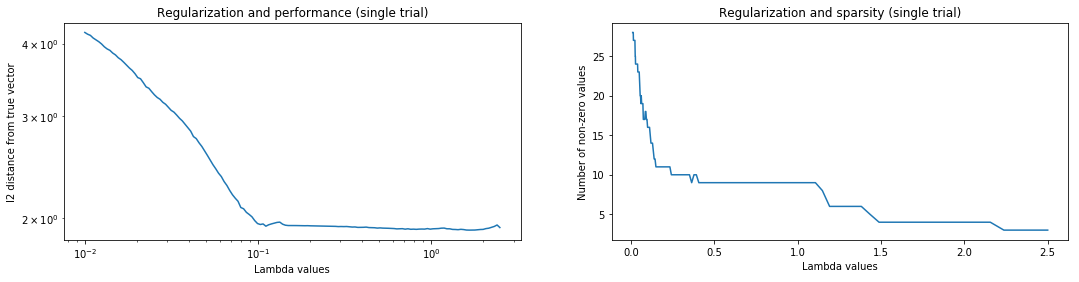

In [39]:

myfig = plt.figure(figsize=(18,4))
ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true vector")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (single trial)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (single trial)")

ax_dist.plot(todo_lambda, dist_overlam)
ax_spar.plot(todo_lambda, spar_overlam)
print('best score =', np.min(dist_overlam))
plt.show()

$\lambda$の順番を変えることにより最高の成績水準がかわり、またそれを実現する$\lambda$の値も変わってしまう。  
これは、$\lambda$の値が大きいものから小さいものへ変化させていくと、学習の最初の段階から非ゼロの要素を大きく削ってしまうことになり、荒い学習となってしまうからであると考えられる。

#### B-2

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import math
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

import numpy as np

todo_lambda = np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150)

dist_overlam = np.zeros(todo_lambda.size) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size)

data_info = dp.NoisyOpt_SmallSparse()
mod = mp.model(data_info)
w_init = mod.w_initialize()

# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = Algo_LASSO_CD(w_init=w_init,\
                       t_max=20*w_init.size,\
                       lam_l1=todo_lambda[i],\
                       verbose=False)
    for mystep in al:
        al.update(model=mod)
    
    # Check performance.
    w_est = al.w
    dist_overlam[i] = mod.evalDist(w_est)
    spar_overlam[i] = mod.evalSparsity(w_est)

print("Done.")

Working...
Done.


best score = 2.54075694769


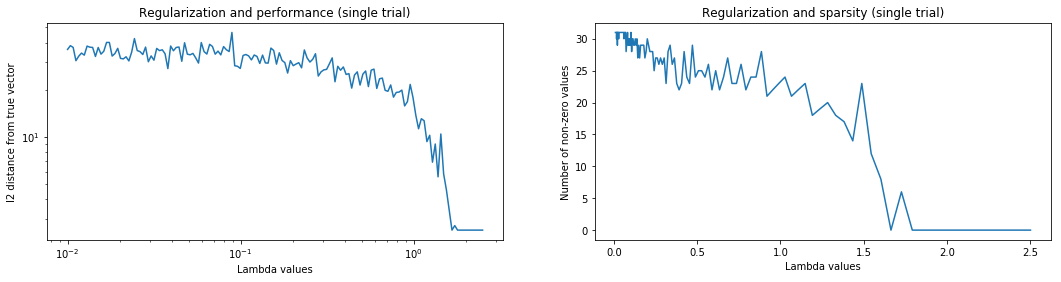

In [42]:

myfig = plt.figure(figsize=(18,4))
ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true vector")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (single trial)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (single trial)")

ax_dist.plot(todo_lambda, dist_overlam)
ax_spar.plot(todo_lambda, spar_overlam)
print('best score =', np.min(dist_overlam))
plt.show()

cold startsにしてしまうとイテレーション毎に別々の学習をしてしまうため、最適解への収束が遅くなり、最高の成績水準が悪くなると共に、それを実現する$\lambda$の値も変わってしまう。  

### 練習問題(c)

#### c-1

In [53]:
def function_for_c_1(num_trials, is_cold_start=False):
    todo_lambda = np.flipud(np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150))
    num_lambda = todo_lambda.size

    dist_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))
    spar_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))

    dist_overlam = np.zeros(todo_lambda.size, dtype=np.float64) # store performance stats for each lambda setting.
    spar_overlam = np.zeros(todo_lambda.size, dtype=np.float64)

    for tr in range(num_trials):

        data_info = dp.NoisyOpt_SmallSparse()
        mod = mp.model(data_info)
        w_init = mod.w_initialize()

        # Iterate over the lambda values once, for a single candidate.
        print("Trial number", tr, "... Working.")
        for i in range(todo_lambda.size):

            # Initialize and execute the algorithm.
            al = Algo_LASSO_CD(w_init=w_init,\
                               t_max=20*w_init.size,\
                               lam_l1=todo_lambda[i],\
                               verbose=False)
            for mystep in al:
                al.update(model=mod)

            # Check performance.
            w_est = al.w

            dist_overlam[i] = mod.evalDist(w_est)
            spar_overlam[i] = mod.evalSparsity(w_est)

            if not is_cold_start:
                # Update the initializer to the most current observation.
                w_init = w_est

        dist_overtrials[tr,:] = dist_overlam
        spar_overtrials[tr,:] = spar_overlam

    dist_ave = np.mean(dist_overtrials, axis=0)
    dist_sd = np.std(dist_overtrials, axis=0)
    spar_ave = np.mean(spar_overtrials, axis=0)
    spar_sd = np.std(dist_overtrials, axis=0)

    dist_argmin = todo_lambda[np.argmin(dist_ave)] # lambda realizing smallest distance.

    myfig = plt.figure(figsize=(18,4))

    ax_dist = myfig.add_subplot(1, 2, 1)
    plt.ylabel("l2 distance from true error")
    plt.xlabel("Lambda values")
    plt.title("Regularization and performance (average)")
    ax_dist.set_yscale('log')
    ax_dist.set_xscale('log')
    plt.axvline(x=dist_argmin, color="black")

    logerr = dist_sd / (math.log(10)*dist_ave) # for error bars when using log scale
    plt.fill_between(todo_lambda, dist_ave-logerr,  
                     dist_ave+logerr, color="lavender")
    ax_dist.plot(todo_lambda, dist_ave)

    ax_spar = myfig.add_subplot(1, 2, 2)
    plt.ylabel("Number of non-zero values")
    plt.xlabel("Lambda values")
    plt.title("Regularization and sparsity (average)")
    plt.axvline(x=dist_argmin, color="black")
    plt.axhline(y=10, color="black")

    err = spar_sd # for error bars in original scale
    plt.fill_between(todo_lambda, spar_ave-err,  
                     spar_ave+err, color="lavender")
    ax_spar.plot(todo_lambda, spar_ave)

    plt.show()
    
    print("Done.")

Trial number 0 ... Working.


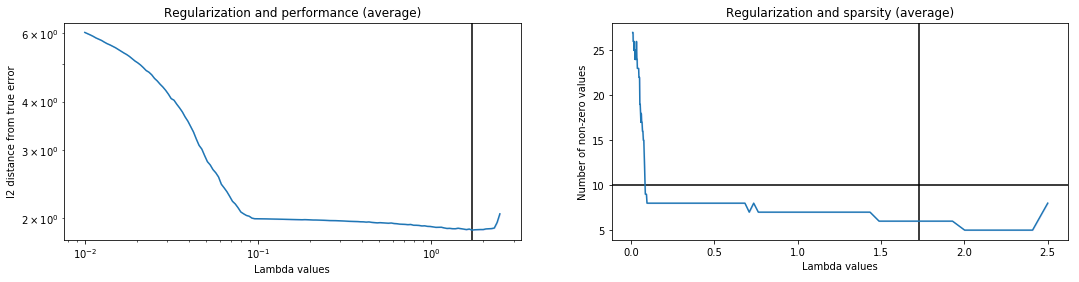

Done.


In [49]:
function_for_c_1(num_trials=1)

Trial number 0 ... Working.
Trial number 1 ... Working.
Trial number 2 ... Working.
Trial number 3 ... Working.
Trial number 4 ... Working.
Trial number 5 ... Working.
Trial number 6 ... Working.
Trial number 7 ... Working.
Trial number 8 ... Working.
Trial number 9 ... Working.


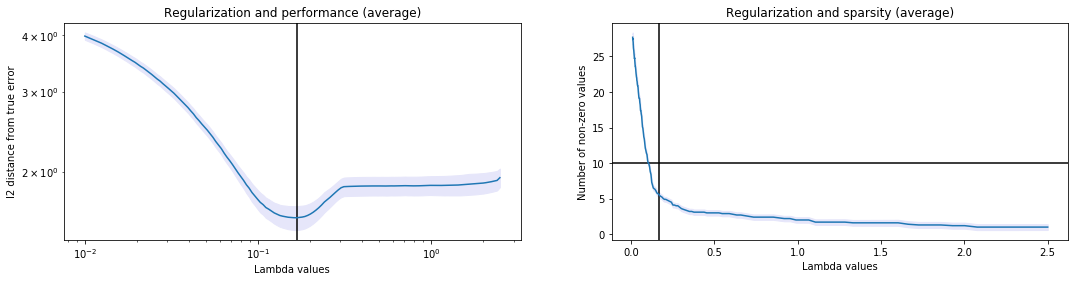

Done.


In [55]:
function_for_c_1(num_trials=10)

各パラメータを何周もさせることで学習が安定する。

#### c-2

Trial number 0 ... Working.
Trial number 1 ... Working.
Trial number 2 ... Working.
Trial number 3 ... Working.
Trial number 4 ... Working.
Trial number 5 ... Working.
Trial number 6 ... Working.
Trial number 7 ... Working.
Trial number 8 ... Working.
Trial number 9 ... Working.


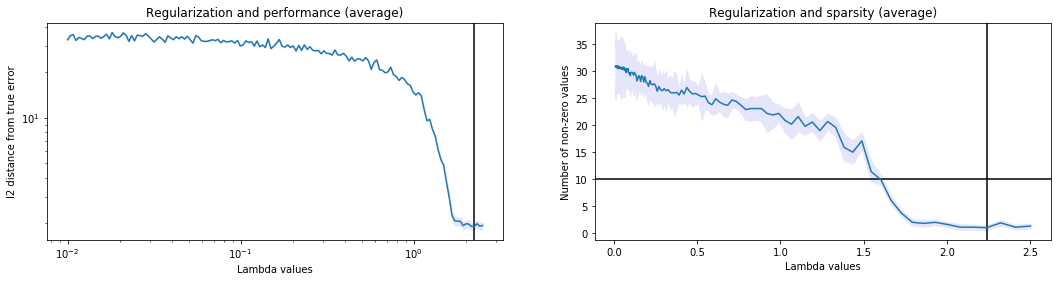

Done.


In [56]:
function_for_c_1(num_trials=10, is_cold_start=True)

cold startとした場合、パフォーマンスの平均・分散、スパース性の平均・分散共に大きくなる。  
これは前回の学習結果を反映できないため学習の収束が遅く、またイテレーション毎の結果も大きく変わってしまうという直感と一致する。

#### c-3

In [59]:
def function_for_c_3(num_trials):
    todo_lambda = np.flipud(np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150))
    num_lambda = todo_lambda.size

    dist_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))
    spar_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))

    dist_overlam = np.zeros(todo_lambda.size, dtype=np.float64) # store performance stats for each lambda setting.
    spar_overlam = np.zeros(todo_lambda.size, dtype=np.float64)

    best_lambda_list = []
    
    for tr in range(num_trials):

        data_info = dp.NoisyOpt_SmallSparse()
        mod = mp.model(data_info)
        w_init = mod.w_initialize()

        # Iterate over the lambda values once, for a single candidate.
        print("Trial number", tr, "... Working.")
        for i in range(todo_lambda.size):

            # Initialize and execute the algorithm.
            al = Algo_LASSO_CD(w_init=w_init,\
                               t_max=20*w_init.size,\
                               lam_l1=todo_lambda[i],\
                               verbose=False)
            for mystep in al:
                al.update(model=mod)

            # Check performance.
            w_est = al.w

            dist_overlam[i] = mod.evalDist(w_est)
            spar_overlam[i] = mod.evalSparsity(w_est)
            
            # Update the initializer to the most current observation.
            w_init = w_est

        dist_overtrials[tr,:] = dist_overlam
        spar_overtrials[tr,:] = spar_overlam
        
        best_lambda_list.append(todo_lambda[np.argmin(dist_overlam)])

    dist_ave = np.mean(dist_overtrials, axis=0)
    dist_sd = np.std(dist_overtrials, axis=0)
    spar_ave = np.mean(spar_overtrials, axis=0)
    spar_sd = np.std(dist_overtrials, axis=0)

    
    dist_argmin = todo_lambda[np.argmin(dist_ave)] # lambda realizing smallest distance.

    myfig = plt.figure(figsize=(18,4))

    ax_dist = myfig.add_subplot(1, 2, 1)
    plt.ylabel("l2 distance from true error")
    plt.xlabel("Lambda values")
    plt.title("Regularization and performance (average)")
    ax_dist.set_yscale('log')
    ax_dist.set_xscale('log')
    plt.axvline(x=dist_argmin, color="black")

    logerr = dist_sd / (math.log(10)*dist_ave) # for error bars when using log scale
    plt.fill_between(todo_lambda, dist_ave-logerr,  
                     dist_ave+logerr, color="lavender")
    ax_dist.plot(todo_lambda, dist_ave)

    ax_spar = myfig.add_subplot(1, 2, 2)
    plt.ylabel("Number of non-zero values")
    plt.xlabel("Lambda values")
    plt.title("Regularization and sparsity (average)")
    plt.axvline(x=dist_argmin, color="black")
    plt.axhline(y=10, color="black")

    err = spar_sd # for error bars in original scale
    plt.fill_between(todo_lambda, spar_ave-err,  
                     spar_ave+err, color="lavender")
    ax_spar.plot(todo_lambda, spar_ave)

    plt.show()
    
    best_lambda_list = np.array(best_lambda_list)
    print('Mean of best lambda =', best_lambda_list.mean())
    print('Std of best lambda =', best_lambda_list.std())

    print("Done.")

Trial number 0 ... Working.
Trial number 1 ... Working.
Trial number 2 ... Working.
Trial number 3 ... Working.
Trial number 4 ... Working.
Trial number 5 ... Working.
Trial number 6 ... Working.
Trial number 7 ... Working.
Trial number 8 ... Working.
Trial number 9 ... Working.


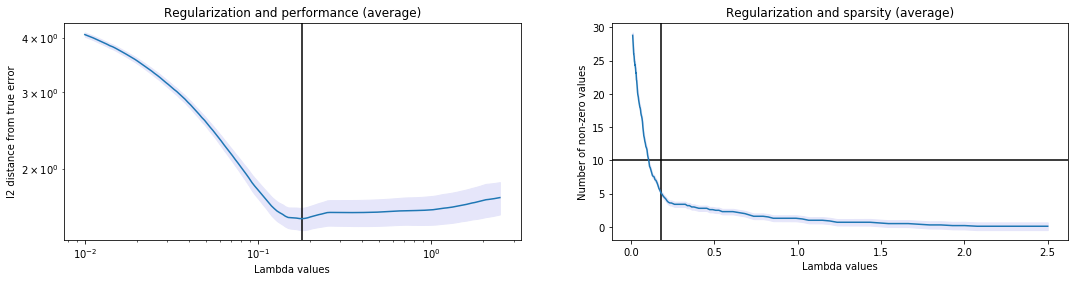

Mean of best lambda = 0.949560843167
Std of best lambda = 1.05707378816
Done.


In [61]:
function_for_c_3(10)